In [143]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from matplotlib.animation import FuncAnimation

plt.style.use('seaborn-v0_8-dark')
np.__version__

'1.26.4'

### 1.1 EulerAngles to Rotation Matrix

Following the ZYX convention, 

$$
\begin{align}
R &= R_{z}(\theta_{1}) \cdot R_{y}(\theta_{2}) \cdot R_{x}(\theta_{3}) \\
\implies R &= \begin{bmatrix}
\cos(\theta_1) & -\sin(\theta_1) & 0 \\
\sin(\theta_1) & \cos(\theta_1) & 0 \\
0 & 0 & 1
\end{bmatrix}

\begin{bmatrix}
\cos(\theta_2) & 0 & \sin(\theta_2) \\
0 & 1 & 0 \\
-\sin(\theta_2) & 0 & \cos(\theta_2)
\end{bmatrix}

\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos(\theta_3) & -\sin(\theta_3) \\
0 & \sin(\theta_3) & \cos(\theta_3) \\
\end{bmatrix}


\end{align}
$$


In [12]:
def getR(theta, axis):
    if axis == 'x':
        return np.array([[1, 0, 0],
                        [0, np.cos(theta), -np.sin(theta)],
                        [0, np.sin(theta), np.cos(theta)]])
    elif axis == 'y':
        return np.array([[np.cos(theta), 0, np.sin(theta)],
                        [0, 1, 0],
                        [-np.sin(theta), 0, np.cos(theta)]])``
    elif axis == 'z':
        return np.array([[np.cos(theta), -np.sin(theta), 0],
                        [np.sin(theta), np.cos(theta), 0],
                        [0, 0, 1]])    
    

def euler2R(theta):
    return getR(theta[0], 'z') @ getR(theta[1], 'y') @ getR(theta[2], 'x')

euler2R([np.pi/2, 0, -np.pi/3])

array([[ 6.12323400e-17, -5.00000000e-01, -8.66025404e-01],
       [ 1.00000000e+00,  3.06161700e-17,  5.30287619e-17],
       [ 0.00000000e+00, -8.66025404e-01,  5.00000000e-01]])

### 1.2 Rotation Matrix to Euler Angles

The final rotation matrix for ZYX convention is given by, 
$$
\begin{align}
R = \begin{bmatrix}
\cos(\theta_1)\cos(\theta_2) & -\cos(\theta_1)\sin(\theta_3) + \sin(\theta_1)\sin(\theta_2)\cos(\theta_3) & \cos(\theta_1)\sin(\theta_2)\sin(\theta_3) + \sin(\theta_1)\cos(\theta_3) \\
\sin(\theta_1)\cos(\theta_2) & -\sin(\theta_1)\sin(\theta_3) - \cos(\theta_1)\sin(\theta_2)\cos(\theta_3) & \sin(\theta_1)\sin(\theta_2)\sin(\theta_3) - \cos(\theta_1)\cos(\theta_3) \\
-\sin(\theta_2) & \cos(\theta_2)\sin(\theta_3) & \cos(\theta_2)\cos(\theta_3)
\end{bmatrix}
\end{align}
$$

Therefore, upong solving we get, 

$$
\begin{align}
\theta_{1} &= \arctan2(R_{[1, 0]}, R_{[0, 0]}) \\
\theta_{2} &= -\arcsin(R_{[2,1]}) \\
\theta_{3} &= \arctan2(R_{[2, 1]}, R_{[2, 2]}) \\
\end{align}
$$

In [15]:
def R2euler(R):
    if np.abs(R[2, 0]) != 1:
        theta2 = -np.arcsin(R[2, 0])
        cos_theta2 = np.cos(theta2)
        theta1 = np.arctan2(R[2, 1] / cos_theta2, R[2, 2] / cos_theta2)  
        theta3 = np.arctan2(R[1, 0] / cos_theta2, R[0, 0] / cos_theta2)  
    else:
        # where there is a gimbal lock
        theta2 = np.pi / 2 if R[2, 0] == -1 else -np.pi / 2
        theta1 = np.arctan2(-R[0, 1], R[1, 1])
        theta3 = 0 

    return theta1, theta2, theta3

R2euler(euler2R([np.pi/2, 0, -np.pi/3])) == (-np.pi/3, 0, np.pi/2)

True

### 2.1 3R manipulator EEF position

In [206]:
class Manipulator:
    def __init__(self, l1=1, l2=0.5, l3=0.25):
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3
        
        self.x1_init = np.array([self.l1, 0, 0])
        self.x2_init = np.array([self.l2, 0, 0])
        self.x3_init = np.array([self.l3, 0, 0])
        
        self.theta1 = self.theta2 = self.theta3 = 0

    def forward_kinematics(self, theta1, theta2, theta3):
        self.theta1 = np.deg2rad(theta1)
        self.theta2 = np.deg2rad(theta2)
        self.theta3 = np.deg2rad(theta3)
        R01 = euler2R([self.theta1, 0, 0]) 
        R12 = euler2R([self.theta2, 0, 0])
        R23 = euler2R([self.theta3, 0, 0])
        
        self.x1 = R01 @ (self.x1_init)
        self.x2 = (R12 @ self.x2_init) + self.x1
        self.x3 = (R23 @ self.x3_init) + self.x2
        
    def inverse_kinematics(self, x, y):
        pass
    
    def visualize(self, alpha=1.0):
        plt.plot([0, self.x1[0]], [0, self.x1[1]], 'r-', marker='o', alpha=alpha)
        plt.plot([self.x1[0], self.x2[0]], [self.x1[1], self.x2[1]], 'g-', marker='o', alpha=alpha)
        plt.plot([self.x2[0], self.x3[0]], [self.x2[1], self.x3[1]], 'b-', alpha=alpha)
        
        plt.ylim(-2, 2)
        plt.xlim(-2, 2)
        plt.grid(True)
        

In [207]:
arm = Manipulator()


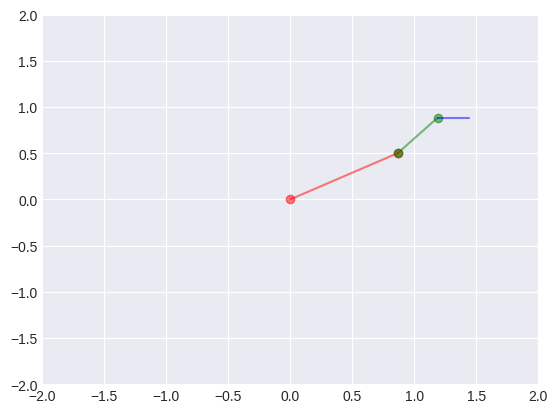

In [208]:
arm.forward_kinematics(theta1=30, theta2=50, theta3=0)
arm.visualize(alpha=0.5)
